<a href="https://colab.research.google.com/github/josephcostello2/baseball-ops-scouting-automation/blob/main/Glasnow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. INSTALL THE LIBRARY FIRST
# (The '!' tells the notebook to run a terminal command)
!pip install pybaseball

# 2. NOW IMPORT IT
import pandas as pd
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

# 3. RUN THE REST OF THE CODE
# Find Player ID (e.g., Tyler Glasnow)
# Note: The first time you run this, it might take a moment to download the player lookup table.
player_stats = playerid_lookup('glasnow', 'tyler')
player_id = player_stats['key_mlbam'].values[0]

# Fetch Data (Season to Date)
# We use a static start date for the 2024 season as an example
print("Fetching data... this may take a few seconds.")
df = statcast_pitcher(start_dt='2024-03-28', end_dt=str(date.today()), player_id=player_id)

print(f"Data fetched: {len(df)} pitches found.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.2 MB/s eta 0:00:00
Gathering player lookup table. This may take a moment.
Fetching data... this may take a few seconds.
Gathering Player Data
Data fetched: 3925 pitches found.


In [4]:
# ---------------------------------------------------------
# CELL 2: SQL DATABASE CREATION & MANAGEMENT
# ---------------------------------------------------------

# 1. Create (or connect to) a local SQLite database
# This creates a file named 'dodgers_scouting.db' in your current folder
conn = sqlite3.connect('dodgers_scouting.db')

# 2. Select relevant columns to keep the database clean
# We are filtering the raw dataframe 'df' from Cell 1
cols_to_keep = [
    'game_date', 'pitch_type', 'release_speed', 'description',
    'events', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'stand',
    'sz_top', 'sz_bot' # Added strike zone top/bottom for plotting later
]

# Quick clean: drop rows where essential tracking data is missing
clean_df = df[cols_to_keep].dropna(subset=['pitch_type', 'pfx_x', 'pfx_z'])

# 3. Dump the data into SQL
# 'if_exists="replace"' means we overwrite the table each time we run this
clean_df.to_sql('raw_pitching_data', conn, if_exists='replace', index=False)

# 4. PROOF OF WORK: Query the data back using SQL
# We calculate the average velocity per pitch type using SQL syntax
query_usage = """
SELECT
    pitch_type,
    COUNT(*) as pitch_count,
    ROUND(AVG(release_speed), 1) as avg_velocity
FROM raw_pitching_data
GROUP BY pitch_type
ORDER BY pitch_count DESC
"""

sql_results = pd.read_sql(query_usage, conn)

print("✅ Data successfully stored in SQL.")
print("📊 Pitch Usage Report (Generated via SQL Query):")
display(sql_results) # 'display()' makes it look nice in notebooks; use print() if in a script

✅ Data successfully stored in SQL.
📊 Pitch Usage Report (Generated via SQL Query):


,pitch_type,pitch_count,avg_velocity
0,FF,1559,96.1
1,SL,968,89.8
2,CU,825,82.8
3,SI,568,96.3


In [6]:
# ---------------------------------------------------------
# CELL 3: CALCULATING METRICS (WHIFF RATES)
# ---------------------------------------------------------

# Define what counts as a "Whiff" (Swing and Miss)
whiff_events = ['swinging_strike', 'swinging_strike_blocked', 'foul_tip']
swing_events = whiff_events + ['foul', 'hit_into_play']

# We pull data back from SQL to ensure we are using the stored data
df_analysis = pd.read_sql("SELECT * FROM raw_pitching_data", conn)

# Group by pitch type and calculate stats
metrics = df_analysis.groupby('pitch_type').apply(
    lambda x: pd.Series({
        'Pitches': len(x),
        'Swings': x['description'].isin(swing_events).sum(),
        'Whiffs': x['description'].isin(whiff_events).sum()
    })
).reset_index()

# Calculate Whiff Percentage
# Formula: Whiffs / Swings * 100
metrics['Whiff%'] = (metrics['Whiffs'] / metrics['Swings'] * 100).round(1)

# Filter out pitches thrown rarely (less than 10 times) to remove noise
metrics = metrics[metrics['Pitches'] > 10].sort_values('Whiff%', ascending=False)

print("📉 Whiff Rates by Pitch Type:")
display(metrics[['pitch_type', 'Pitches', 'Whiff%']])

📉 Whiff Rates by Pitch Type:


/tmp/ipython-input-1773363175.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df_analysis.groupby('pitch_type').apply(


,pitch_type,Pitches,Whiff%
0,CU,825,45.5
3,SL,968,40.6
1,FF,1559,21.2
2,SI,568,16.2


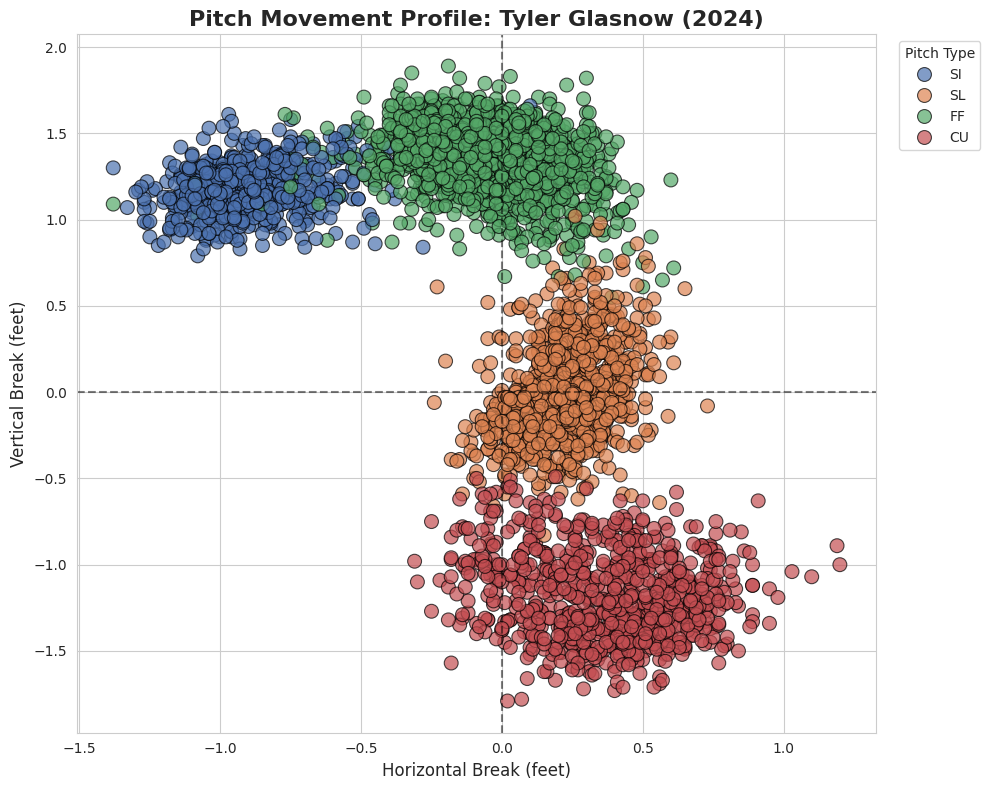

In [7]:
# ---------------------------------------------------------
# CELL 4: VISUALIZATION (MOVEMENT PROFILE)
# ---------------------------------------------------------

# Set the style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot: X axis = Horizontal Break, Y axis = Vertical Break
# 'pfx_x' and 'pfx_z' are usually in feet in raw Statcast data, but pybaseball
# sometimes converts them. We plot them as-is to show the shape.
sns.scatterplot(
    data=df_analysis,
    x='pfx_x',
    y='pfx_z',
    hue='pitch_type',    # Color by pitch type
    palette='deep',      # Color scheme
    s=100,               # Dot size
    alpha=0.7,           # Transparency
    edgecolor='black'    # Border around dots
)

# Add crosshairs at (0,0) to represent the center (no movement)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)

# Labels and Titles
plt.title(f"Pitch Movement Profile: Tyler Glasnow (2024)", fontsize=16, fontweight='bold')
plt.xlabel("Horizontal Break (feet)", fontsize=12)
plt.ylabel("Vertical Break (feet)", fontsize=12)
plt.legend(title='Pitch Type', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

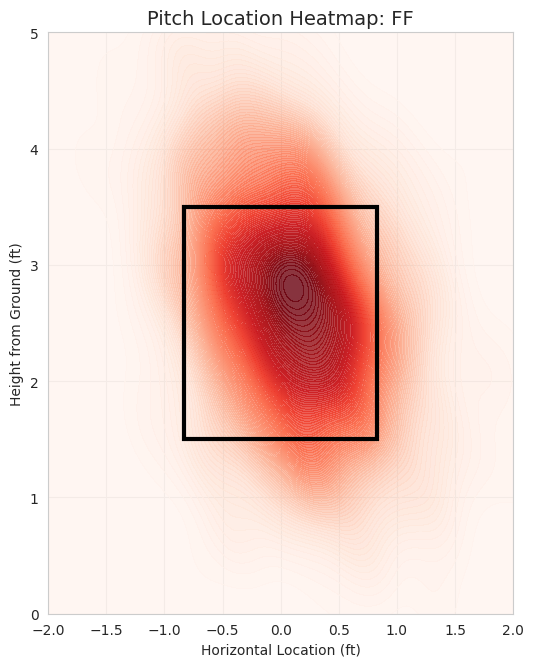

In [8]:
# ---------------------------------------------------------
# CELL 5: STRIKE ZONE HEAT MAPS
# ---------------------------------------------------------

def plot_strike_zone(pitch_type='FF'):
    # Filter for a specific pitch (FF = Four-Seam Fastball)
    pitch_data = df_analysis[df_analysis['pitch_type'] == pitch_type]

    plt.figure(figsize=(6, 8))

    # Create the heatmap
    sns.kdeplot(
        data=pitch_data, x='plate_x', y='plate_z',
        fill=True, cmap='Reds', thresh=0, levels=100, alpha=0.8
    )

    # Draw the Strike Zone (approximate dimensions in feet)
    # plate_x: -0.83 to 0.83 | plate_z: 1.5 to 3.5
    plt.gca().add_patch(plt.Rectangle((-0.83, 1.5), 1.66, 2.0,
                                      edgecolor='black', fill=False, lw=3, label='Strike Zone'))

    plt.xlim(-2, 2)
    plt.ylim(0, 5)
    plt.title(f"Pitch Location Heatmap: {pitch_type}", fontsize=14)
    plt.xlabel("Horizontal Location (ft)")
    plt.ylabel("Height from Ground (ft)")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Change 'FF' to 'CU' (Curveball) or 'SL' (Slider) to see different patterns
plot_strike_zone('FF')